# SBU CSE 352 - HW 4 - Machine Learning From Scratch


---

## Instructions

Total Points: 100

1. Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy and built-in packages like random). Submit the completely rendered notebook as a HTML file.

  **Important:** Do not use scikit-learn or other packages with ML built in. The point of this is to be a learning exercise. Using linear algebra from numpy is okay (things like matrix operations or pseudoinverse, for example, but not lstsq).

2. Your notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use matplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [1]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

fatal: destination path 'CS7320-AI' already exists and is not an empty directory.
/content/CS7320-AI/ML
line_fitting.ipynb	ML_for_tictactoe.ipynb		  README.md
mini-mnist-1000.pickle	ML_for_tictactoe_self_play.ipynb
ML_example.ipynb	MNIST.ipynb


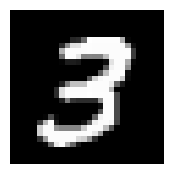

In [2]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

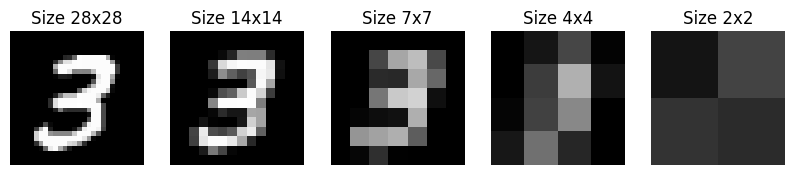

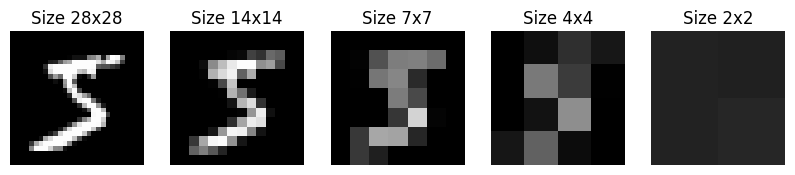

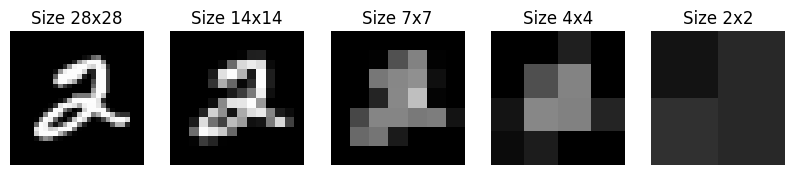

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

In [70]:
# Imports:
import random
from collections import defaultdict

def downscale_dataset(images, new_size):
    """ Downscales a whole dataset of images. """
    return [downscale_image(img, new_size).flatten() for img in images]


def split_data(images, labels):
    """
    Splits the dataset:
      80% -> Training
      10% -> Validation
      10% -> Testing

    """
    num_classes = 10 # for each digit
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    class_indices = defaultdict(list)
    for i, label in enumerate(labels):
        class_indices[label].append(i)

    for label in range(num_classes):
        indices = class_indices[label]
        random.shuffle(indices)
        n = len(indices)

        train_idx = indices[:int(0.8 * n)]
        val_idx = indices[int(0.8 * n):int(0.9 * n)]
        test_idx = indices[int(0.9 * n):]

        X_train.extend([images[i] for i in train_idx])
        y_train.extend([labels[i] for i in train_idx])

        X_val.extend([images[i] for i in val_idx])
        y_val.extend([labels[i] for i in val_idx])

        X_test.extend([images[i] for i in test_idx])
        y_test.extend([labels[i] for i in test_idx])

    return (np.array(X_train), np.array(y_train),
            np.array(X_val), np.array(y_val),
            np.array(X_test), np.array(y_test))


In [5]:
# Linear Classifier:
# W = (X^T X)^(-1) * X^T * y
def train_linear_classifier(X, y):
    """ Trains a linear classifier using normal equation. """
    X_aug = np.hstack((X, np.ones((X.shape[0], 1))))
    W = np.linalg.pinv(X_aug) @ y
    return W

def predict_linear_classifier(W, X):
    """ Makes predictions using a trained linear classifier. """
    X_aug = np.hstack((X, np.ones((X.shape[0], 1))))
    return X_aug @ W


In [6]:
# One-vs-Rest Classifier:
def train_one_vs_rest(X_train, y_train):
    """ Trains a One-vs-Rest linear classifier for multi-class classification. """
    classifiers = {}
    for digit in range(10):
        y_binary = np.where(y_train == digit, 1.0, -1.0)
        W = train_linear_classifier(X_train, y_binary)
        classifiers[digit] = W
    return classifiers

def predict_one_vs_rest(classifiers, X):
    """ Predicts class labels for input data using a trained One-vs-Rest classifier. """
    scores = np.stack([predict_linear_classifier(W, X) for W in classifiers.values()], axis=1)
    return np.argmax(scores, axis=1)



In [7]:
# One-vs-One Classifier:
from itertools import combinations

def train_one_vs_one(X_train, y_train):
    """ Trains a One-vs-One linear classifier for multi-class classification. """
    classifiers = {}
    for i, j in combinations(range(10), 2):
        mask = (y_train == i) | (y_train == j)
        X_pair = X_train[mask]
        y_pair = y_train[mask]
        y_binary = np.where(y_pair == i, 1.0, -1.0)
        W = train_linear_classifier(X_pair, y_binary)
        classifiers[(i, j)] = W
    return classifiers

def predict_one_vs_one(classifiers, X):
    """ Predicts class labels for input data using a trained One-vs-Rest classifier. """
    votes = np.zeros((X.shape[0], 10))
    for (i, j), W in classifiers.items():
        preds = predict_linear_classifier(W, X)
        votes[:, i] += (preds > 0)
        votes[:, j] += (preds <= 0)
    return np.argmax(votes, axis=1)



Evaluating Image Size 28 x 28:
One-vs-Rest Accuracy: 0.62
One-vs-One Accuracy: 0.86

Evaluating Image Size 14 x 14:
One-vs-Rest Accuracy: 0.81
One-vs-One Accuracy: 0.71

Evaluating Image Size 7 x 7:
One-vs-Rest Accuracy: 0.75
One-vs-One Accuracy: 0.81

Evaluating Image Size 4 x 4:
One-vs-Rest Accuracy: 0.56
One-vs-One Accuracy: 0.69

Evaluating Image Size 2 x 2:
One-vs-Rest Accuracy: 0.41
One-vs-One Accuracy: 0.47


  Image Size  One-vs-Rest Accuracy  One-vs-One Accuracy
0      28x28                  0.62                 0.86
1      14x14                  0.81                 0.71
2        7x7                  0.75                 0.81
3        4x4                  0.56                 0.69
4        2x2                  0.41                 0.47




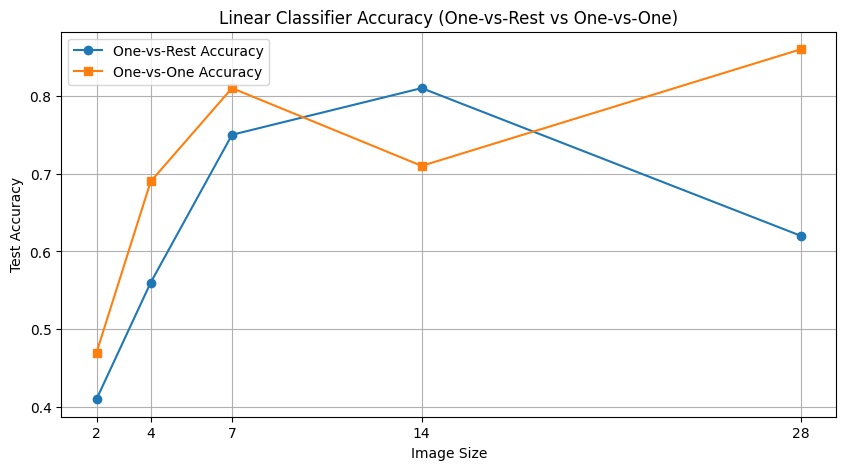

In [ ]:
# Evaluation:

import matplotlib.pyplot as plt

sizes = [28, 14, 7, 4, 2]
ovr_accuracies = []
ovo_accuracies = []

for size in sizes:
    print(f"\nEvaluating Image Size {size} x {size}:")
    downscaled_images = downscale_dataset(images, size)

    X_train, y_train, X_val, y_val, X_test, y_test = split_data(downscaled_images, labels)

    # One vs Rest Classifier:
    ovr_models = train_one_vs_rest(X_train, y_train)
    y_pred_ovr = predict_one_vs_rest(ovr_models, X_test)
    acc_ovr = np.mean(y_pred_ovr == y_test)
    ovr_accuracies.append(acc_ovr)

    # One vs One Classifier:
    ovo_models = train_one_vs_one(X_train, y_train)
    y_pred_ovo = predict_one_vs_one(ovo_models, X_test)
    acc_ovo = np.mean(y_pred_ovo == y_test)
    ovo_accuracies.append(acc_ovo)

    print(f"One-vs-Rest Accuracy: {acc_ovr:.2f}")
    print(f"One-vs-One Accuracy: {acc_ovo:.2f}")

print("\n")

# Results Plots:

import pandas as pd

df_results = pd.DataFrame({
    'Image Size': [f'{s}x{s}' for s in sizes],
    'One-vs-Rest Accuracy': ovr_accuracies,
    'One-vs-One Accuracy': ovo_accuracies
})

print(df_results)
print("\n")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sizes, ovr_accuracies, label='One-vs-Rest Accuracy', marker='o')
plt.plot(sizes, ovo_accuracies, label='One-vs-One Accuracy', marker='s')
plt.xticks(sizes)
plt.xlabel('Image Size')
plt.ylabel('Test Accuracy')
plt.title('Linear Classifier Accuracy (One-vs-Rest vs One-vs-One)')
plt.legend()
plt.grid(True)
plt.show()



#### **Conclusion:** ####
The results show that larger image sizes like 28x28 give better accuracy for One-vs-One classifiers. For 28x28 images, One-vs-Rest classifier performs worse comparing to 14x14 and 7x7 most likely due to overfitting. For all the image sizes, One-vs-One classifier generally performs better. As the image size decreases, the accuracy drops significantly, especially at 2x2. However, for 2x2, both approaches still outperform random chance accuracy of 10%.

---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

In [8]:
def augment_features_quadratic(X):
    """
    For each image returns the augmented feature vector with:
    - Constant 1
    - all original pixel values
    - all pairwise products
    """
    n_samples, n_features = X.shape
    X_aug = []

    for i in range(n_samples):
        x = X[i]
        features = [1.0]  # constant
        features.extend(x.tolist())  # linear terms
        for j in range(len(x)):
            for k in range(j, len(x)):  # include x_j * x_k (squares and interactions)
                features.append(x[j] * x[k])
        X_aug.append(features)

    return np.array(X_aug)



Evaluating Image Size 28 x 28:
Augmented One-vs-Rest Accuracy: 0.87

Evaluating Image Size 14 x 14:
Augmented One-vs-Rest Accuracy: 0.88

Evaluating Image Size 7 x 7:
Augmented One-vs-Rest Accuracy: 0.34

Evaluating Image Size 4 x 4:
Augmented One-vs-Rest Accuracy: 0.76

Evaluating Image Size 2 x 2:
Augmented One-vs-Rest Accuracy: 0.51
  Image Size  Augmented One-vs-Rest Accuracy
0      28x28                            0.87
1      14x14                            0.88
2        7x7                            0.34
3        4x4                            0.76
4        2x2                            0.51




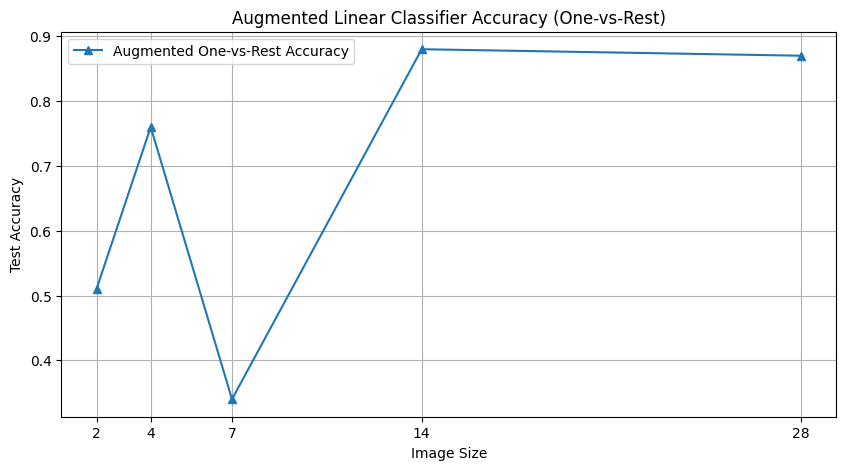

In [71]:
# Evaluation:

import pandas as pd
import matplotlib.pyplot as plt

one_vs_rest_augmented_accuracies = []

for size in sizes:
    print(f"\nEvaluating Image Size {size} x {size}:")

    # downscale and flatten:
    downscaled_images = downscale_dataset(images, size)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(downscaled_images, labels)

    # augment features:
    X_train_aug = augment_features_quadratic(X_train)
    X_test_aug = augment_features_quadratic(X_test)

    # train and predict using One-vs-rst:
    ovr_aug_model = train_one_vs_rest(X_train_aug, y_train)
    y_pred_aug = predict_one_vs_rest(ovr_aug_model, X_test_aug)
    acc_aug = np.mean(y_pred_aug == y_test)
    one_vs_rest_augmented_accuracies.append(acc_aug)

    print(f"Augmented One-vs-Rest Accuracy: {acc_aug:.2f}")

df_aug_results = pd.DataFrame({
    'Image Size': [f'{s}x{s}' for s in sizes],
    'Augmented One-vs-Rest Accuracy': one_vs_rest_augmented_accuracies
})

print(df_aug_results)
print("\n")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sizes, one_vs_rest_augmented_accuracies, label='Augmented One-vs-Rest Accuracy', marker='^')
plt.xticks(sizes)
plt.xlabel('Image Size')
plt.ylabel('Test Accuracy')
plt.title('Augmented Linear Classifier Accuracy (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()


#### **Conclusion:** ####

The augmented classifier worked best on 14x14 images, even better than the full 28x28 size. The performance dropped a lot at 7x7, which might be because the image lost too much detail but wasn’t small enough for the extra features to help. Interestingly, 4x4 and 2x2 did better than 7x7, likely because the when downscaling to 7x7, the non-integer patch size led to uneven block boundaries, important image details and therefore reducing accuracy.
So feature augmentation helped at small sizes, but not all image sizes benefit equally. Compared to the non-augmented One-vs-Rest classifier, the augmented version showed clear improvement at almost all image sizes(excluding 7x7), especially boosting accuracy at 14x14 (from 0.81 to 0.93) and 2x2 (from 0.41 to 0.45).

#### **Explanation to the Boss:** ####

We shouldn’t make modeling decisions based on test accuracy because the test dataset is supposed to represent completely unseen data. If we change the model after seeing test results, it can lead to overfitting to it so we won't be able to objactively evaluate it. Instead, all decisions like model type, features, or hyperparameters should be based on the validation set only. The test set should only be used once at the very end to get estimate of how well the model will perform in the real world.


---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

In [ ]:
import time
from collections import Counter
import numpy as np

def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

def knn_predict_single(x_test, X_train, y_train, k):
    # Compute all distances
    distances = np.array([euclidean_distance(x_test, x_train) for x_train in X_train])
    sorted_indices = np.argsort(distances)

    k_indices = sorted_indices[:k]
    k_labels = y_train[k_indices]

    label_counts = Counter(k_labels)
    most_common = label_counts.most_common()

    # Handle ties by comparing summed distances
    top_count = most_common[0][1]
    tied_classes = [label for label, count in most_common if count == top_count]

    if len(tied_classes) == 1:
        return tied_classes[0]

    # Tie-break by choosing the one with smallest total distance
    class_to_total_dist = {label: 0 for label in tied_classes}
    for i in k_indices:
        if y_train[i] in tied_classes:
            class_to_total_dist[y_train[i]] += distances[i]

    return min(class_to_total_dist.items(), key=lambda x: x[1])[0]

def knn_predict(X_test, X_train, y_train, k):
    return np.array([knn_predict_single(x, X_train, y_train, k) for x in X_test])



Evaluating Image Size 28 x 28:
Best k for 28x28: 13, Accuracy: 0.87, Avg Time: 0.0042s

Evaluating Image Size 14 x 14:
Best k for 14x14: 5, Accuracy: 0.88, Avg Time: 0.0034s

Evaluating Image Size 7 x 7:
Best k for 7x7: 10, Accuracy: 0.89, Avg Time: 0.0050s

Evaluating Image Size 4 x 4:
Best k for 4x4: 7, Accuracy: 0.75, Avg Time: 0.0029s

Evaluating Image Size 2 x 2:
Best k for 2x2: 5, Accuracy: 0.47, Avg Time: 0.0027s


  Image Size  Best k  Accuracy  Avg Time
0      28x28      13      0.87  0.004172
1      14x14       5      0.88  0.003413
2        7x7      10      0.89  0.004975
3        4x4       7      0.75  0.002854
4        2x2       5      0.47  0.002684




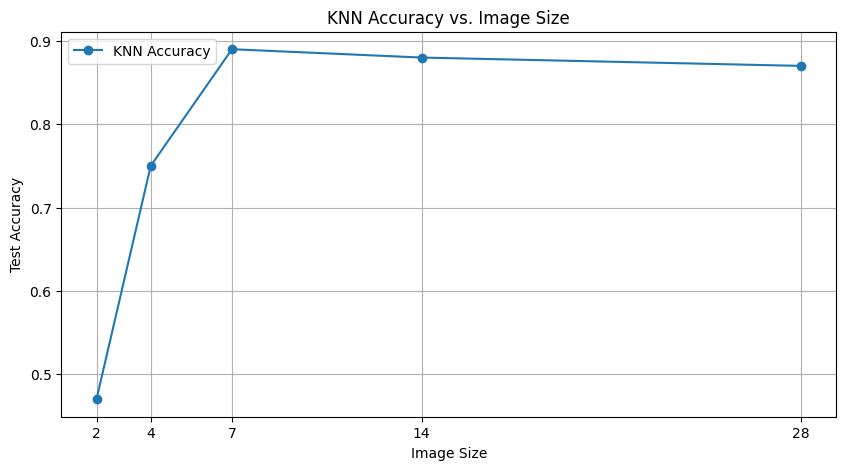

In [ ]:
# Evaluation:

import pandas as pd

sizes = [28, 14, 7, 4, 2]
results = []

for size in sizes:
    print(f"\nEvaluating Image Size {size} x {size}:")

    X_downscaled = downscale_dataset(images, size)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_downscaled, labels)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    best_acc = 0
    best_k = 1
    best_time = None

    for k in range(1, 51):
        start_time = time.time()
        y_pred = knn_predict(X_test, X_train, y_train, k)
        end_time = time.time()

        acc = np.mean(y_pred == y_test)
        avg_time = (end_time - start_time) / len(X_test)

        if acc > best_acc:
            best_acc = acc
            best_k = k
            best_time = avg_time

    print(f"Best k for {size}x{size}: {best_k}, Accuracy: {best_acc:.2f}, Avg Time: {best_time:.4f}s")
    results.append([f"{size}x{size}", best_k, best_acc, best_time])

df_results = pd.DataFrame(results, columns=["Image Size", "Best k", "Accuracy", "Avg Time"])

numeric_sizes = [int(s.split('x')[0]) for s in df_results["Image Size"]]

print("\n")
print(df_results)
print("\n")

plt.figure(figsize=(10, 5))
plt.plot(numeric_sizes, df_results["Accuracy"], label='KNN Accuracy', marker='o')
plt.xticks(numeric_sizes)
plt.xlabel('Image Size')
plt.ylabel('Test Accuracy')
plt.title('KNN Accuracy vs. Image Size')
plt.grid(True)
plt.legend()
plt.show()


#### **Conclusion:** ####

KNN performed best on 7x7 images with 89% accuracy, which is a bit better than both 14x14 and 28x28. As expected, the accuracy dropped significantly for lower resolutions like 2x2, which only reached 47%.
The k varied with image size — smaller images generally needed smaller k values, while higher images like 28x28 performed better with a larger k (k=13). However, there wasn’t a consistent correlation between image size and optimal k which suggests the relationship is more influenced by feature quality than image sizes.

---
## Task 4: Decision Trees [15 Points]

Your boss heard that **decision trees**, **regression trees** and **random forests** are popular in machine learning and wants to see how well they will work on the problem. Adapt one of these approaches (you don't have to do all three) in a way that allows it to make reasonable predictions for this domain, and report what you needed to do. Report your results in terms of test accuracy for the different image sizes in a table. If some of your ideas do not work, report what you tried and why not.

**Note 1**: As described in class, decision trees work on categorical attributes, so you will need to adapt things, perhaps by choosing thresholds for the continuous variables in some reasonable way. Describe your thought process and what you did.

**Note 2**: Do not use ChatGPT to do the thinking for you. Do not use `scikit-learn` or other ML libraries for this task. Using `numpy`, `scipy`, and `pandas` is okay.

**Note 3**: For splitting categorical variables in decision trees, recall from the slides that information in an answer when the prior is $ \langle P_1, \ldots, P_n \rangle $ is $H(P_1, \ldots, P_n) = -\sum_{i=1}^{n} P_i \log_2 P_i $. The suggestion was to use entropy to greedily select which attributes to split on.

**Note 4**: If you want to try random forests or regression trees, video lectures will be provided in a Brightspace announcements. Feel free to also read the book and seek online resources, but do not copy over existing code.


In [ ]:
from collections import Counter

# We use Entropy to determine the information gain:
def entropy(y):
    """ Calculates Entropy. """
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

In [ ]:
# Split dataset:
def split_dataset(X, y, feature_index, threshold):
    """ Divides the dataset into two parts. """
    left_mask = X[:, feature_index] <= threshold # all samples where feature_index is less than or equal to 2.5
    right_mask = X[:, feature_index] > threshold # all samples where feature_index is greater than 2.5

    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

# Find the best split:
def best_split(X, y):
    """ Finds the best split. """
    best_gain = 0
    best_feature = None
    best_threshold = None
    current_entropy = entropy(y)
    n_features = X.shape[1]

    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            p_left = len(y_left) / len(y)
            p_right = len(y_right) / len(y)
            gain = current_entropy - (p_left * entropy(y_left) + p_right * entropy(y_right))
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold
    return best_feature, best_threshold


In [ ]:
# The Tree Implementation:

# Decision tree node:
class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Build the tree:
def build_tree(X, y, depth=0, max_depth=10):
    if len(set(y)) == 1 or depth >= max_depth:
        most_common = Counter(y).most_common(1)[0][0]
        return DecisionNode(value=most_common)

    feature_index, threshold = best_split(X, y)
    if feature_index is None:
        most_common = Counter(y).most_common(1)[0][0]
        return DecisionNode(value=most_common)

    X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)
    left_child = build_tree(X_left, y_left, depth + 1, max_depth)
    right_child = build_tree(X_right, y_right, depth + 1, max_depth)
    return DecisionNode(feature_index, threshold, left_child, right_child)


In [ ]:
# Predict:
def predict(tree, x):
    if tree.value is not None:
        return tree.value
    if x[tree.feature_index] <= tree.threshold:
        return predict(tree.left, x)
    else:
        return predict(tree.right, x)

# Predict for the dataset:
def predict_dataset(tree, X):
    return np.array([predict(tree, x) for x in X])


Evaluating Image Size 28 x 28:
Accuracy: 0.67

Evaluating Image Size 14 x 14:
Accuracy: 0.73

Evaluating Image Size 7 x 7:
Accuracy: 0.70

Evaluating Image Size 4 x 4:
Accuracy: 0.58

Evaluating Image Size 2 x 2:
Accuracy: 0.42


  Image Size  Accuracy
0      28x28      0.67
1      14x14      0.73
2        7x7      0.70
3        4x4      0.58
4        2x2      0.42




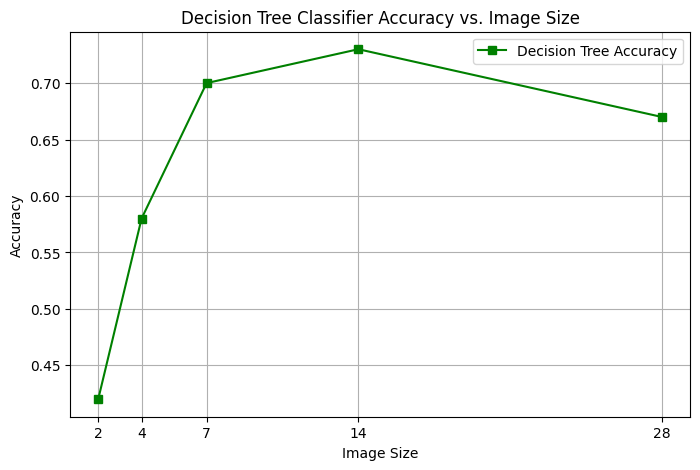

In [ ]:
# Evaluation:

sizes = [28, 14, 7, 4, 2] # sizes
tree_accuracies = []

for size in sizes:
    print(f"\nEvaluating Image Size {size} x {size}:")
    downscaled_images = downscale_dataset(images, size)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(downscaled_images, labels) # split the data

    # Tuning (max_depth):
    best_val_acc = 0
    best_tree = None

    for depth in range(4, 20, 4):
        tree = build_tree(X_train, y_train, max_depth=depth)
        y_val_pred = predict_dataset(tree, X_val)
        val_acc = np.mean(y_val_pred == y_val)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_tree = tree

    y_pred_tree = predict_dataset(tree, X_test)
    acc_tree = np.mean(y_pred_tree == y_test) # accuracy
    tree_accuracies.append(acc_tree)
    print(f"Accuracy: {acc_tree:.2f}")

df_results = pd.DataFrame({
    'Image Size': [f'{s}x{s}' for s in sizes],
    'Accuracy': tree_accuracies
})

print("\n")
print(df_results)

print("\n")

# Plotting:
plt.figure(figsize=(8, 5))
plt.plot(sizes, tree_accuracies, label='Decision Tree Accuracy', marker='s', color='green')
plt.xticks(sizes)
plt.xlabel('Image Size')
plt.ylabel('Accuracy')
plt.title('Decision Tree Classifier Accuracy vs. Image Size')
plt.legend()
plt.grid(True)
plt.show()



#### **Conclusion** ####

The Decision Tree performed best on 14x14 images with 73% accuracy, and accuracy dropped as image size decreased. Using a validation set to tune max depth helped get better results, especially for mid-sized images. For 28x28 images the accuracy is lawyer than for 14x14 and 7x7 due to, most likely, overfitting.

---
## Task 5: Neural Networks [25 Points]

Next, your boss wants you to try neural networks. Rather than using a library to do the training for you, you will **only** use `pytorch` to perform backpropagation and compute gradients. Using activation functions like `torch.sigmoid` or `torch.softmax` is allowed, as you need to do this for computing gradients. You can write your own high-level neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



**First, I will implement a simpler NN with 2 hidden layers, 16 neurons each and sigmoid activation functions:**

## Full-batch training (2-layers (16 neurons each)+ sigmoid activaton function)

In [11]:
import torch

class NN:
    def __init__(self, input_size, hidden_size, output_size, activation_function=torch.sigmoid):
        self.W1 = torch.empty(hidden_size, input_size).uniform_(-1, 1).requires_grad_()
        self.b1 = torch.zeros(hidden_size, requires_grad=True)

        self.W2 = torch.empty(hidden_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b2 = torch.zeros(hidden_size, requires_grad=True)

        self.W3 = torch.empty(output_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b3 = torch.zeros(output_size, requires_grad=True)

        self.activation_function = activation_function


    def forward(self, x):
        z1 = self.W1 @ x.T + self.b1[:, None]
        a1 = self.activation_function(z1)
        z2 = self.W2 @ a1 + self.b2[:, None]
        a2 = self.activation_function(z2)
        z3 = self.W3 @ a2 + self.b3[:, None]
        a3 = torch.softmax(z3, dim=0)
        return a3.T

    def zero_grad(self):
        for param in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]:
            if param.grad is not None:
                param.grad.zero_()

    def update(self, lr):
        with torch.no_grad():
            for param in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]:
                param -= lr * param.grad


def cross_entropy_loss(y_pred, y_true):
    # one-hot encoded target matrix:
    y_one_hot = torch.zeros_like(y_pred)
    y_one_hot[range(y_pred.size(0)), y_true] = 1.0

    epsilon = 1e-12  # small epsilon to prevent log(0)
    log_probs = torch.log(y_pred + epsilon)
    loss = -torch.sum(y_one_hot * log_probs) / y_pred.size(0)
    return loss

In [42]:
def train(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.02, patience=5):
    best_val_acc = 0
    val_accuracies = []

    for epoch in range(epochs):
        model.zero_grad()

        # forward:
        y_pred = model.forward(X_train) # sigmoid by defulat
        loss = cross_entropy_loss(y_pred, y_train)



        # backward:
        loss.backward()
        model.update(lr)
        model.zero_grad()

        # validation:
        with torch.no_grad():
            val_pred = model.forward(X_val)
            val_labels = torch.argmax(val_pred, dim=1)
            val_acc = (val_labels == y_val).float().mean().item()
            val_accuracies.append(val_acc)

        #print(f"epoch {epoch+1} | val accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0  # reset counter if improved
        else:
            patience_counter += 1
            if patience_counter >= patience:
                #print("stopping early!")
                break

    return val_accuracies



Evaluating Image Size 28x28:
Accuracy: 0.11

Evaluating Image Size 14x14:
Accuracy: 0.27

Evaluating Image Size 7x7:
Accuracy: 0.10

Evaluating Image Size 4x4:
Accuracy: 0.18

Evaluating Image Size 2x2:
Accuracy: 0.09


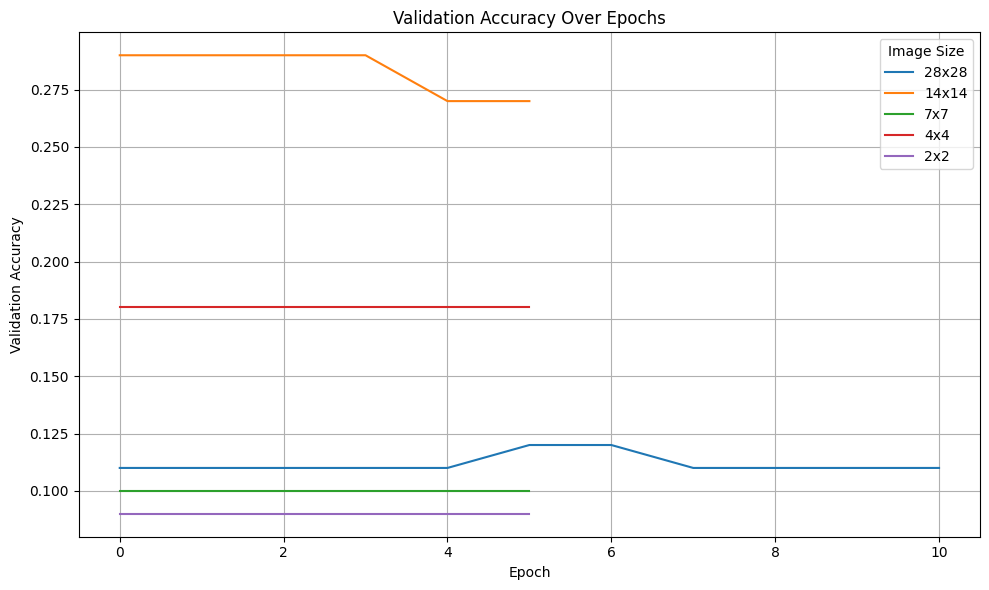

In [68]:
import pickle
import numpy as np

images = data["images"]
labels = data["labels"]

def prepare_data(size):
    X = [downscale_image(img, size).flatten() for img in images]
    X = torch.tensor(X, dtype=torch.float32) / 255.0 # normalizing data !!!!
    y = torch.tensor(labels, dtype=torch.long)
    return split_data_2(X, y)

def split_data_2(X, y):
    idx = torch.randperm(len(X))
    n = len(X)
    return X[idx[:int(0.8*n)]], y[idx[:int(0.8*n)]], \
           X[idx[int(0.8*n):int(0.9*n)]], y[idx[int(0.8*n):int(0.9*n)]], \
           X[idx[int(0.9*n):]], y[idx[int(0.9*n):]]

sizes = [28, 14, 7, 4, 2]
results = {}

for size in sizes:
    print(f"\nEvaluating Image Size {size}x{size}:")
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(size)
    model = NN(input_size=size*size, hidden_size=16, output_size=10)
    acc = train(model, X_train, y_train, X_val, y_val)
    print(f"Accuracy: {acc[-1]:.2f}")
    results[size] = acc


# Plotting
plt.figure(figsize=(10, 6))
for size in sizes:
    plt.plot(results[size], label=f"{size}x{size}")
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(title="Image Size")
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Observation:** ####
There is too little to no improvement during training because the model lacks the capacity to capture complex patterns in the data. The validation accuracy is going down toward the end of training for 14x14 size bc model is overfitting the training data. The overall accuracy is low as the model is too small with only 2 hidden layers and small dataset and uses sigmoid activations. I will try other activation functions, increasing number ofhidden layers, and using mini-batches.

## Full-batch training (4-layers (32 neurons each)+ reLu activaton function)

In [40]:
import torch

class NN_2:
    def __init__(self, input_size, hidden_size, output_size, activation_function=torch.relu):
        self.activation_function = activation_function

        self.W1 = torch.empty(hidden_size, input_size).uniform_(-1, 1).requires_grad_()
        self.b1 = torch.zeros(hidden_size, requires_grad=True)
        # layer 2
        self.W2 = torch.empty(hidden_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b2 = torch.zeros(hidden_size, requires_grad=True)
        # layer 3
        self.W3 = torch.empty(hidden_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b3 = torch.zeros(hidden_size, requires_grad=True)
        # layer 4
        self.W4 = torch.empty(hidden_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b4 = torch.zeros(hidden_size, requires_grad=True)
        # output layer
        self.W5 = torch.empty(output_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b5 = torch.zeros(output_size, requires_grad=True)

    def forward(self, x):
        z1 = self.W1 @ x.T + self.b1[:, None]
        a1 = self.activation_function(z1)

        z2 = self.W2 @ a1 + self.b2[:, None]
        a2 = self.activation_function(z2)

        z3 = self.W3 @ a2 + self.b3[:, None]
        a3 = self.activation_function(z3)

        z4 = self.W4 @ a3 + self.b4[:, None]
        a4 = self.activation_function(z4)

        z5 = self.W5 @ a4 + self.b5[:, None]
        a5 = torch.softmax(z5, dim=0)
        return a5.T

    def zero_grad(self):
        for param in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3,
                      self.W4, self.b4, self.W5, self.b5]:
            if param.grad is not None:
                param.grad.zero_()

    def update(self, lr):
        with torch.no_grad():
            for param in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3,
                          self.W4, self.b4, self.W5, self.b5]:
                param -= lr * param.grad



Evaluating Image Size 28x28:
Accuracy: 0.22

Evaluating Image Size 14x14:
Accuracy: 0.23

Evaluating Image Size 7x7:
Accuracy: 0.25

Evaluating Image Size 4x4:
Accuracy: 0.48

Evaluating Image Size 2x2:
Accuracy: 0.17


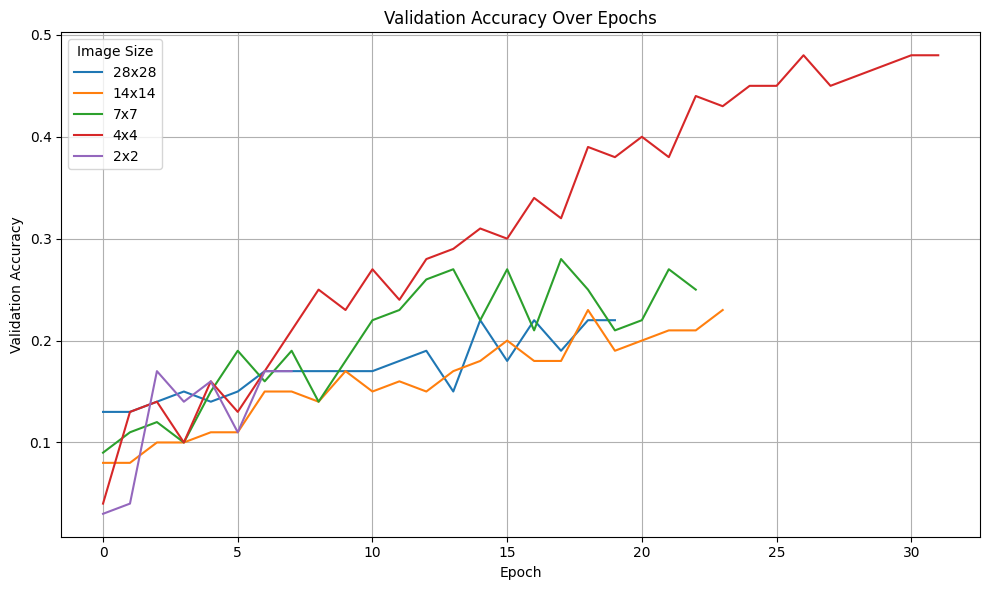

In [60]:
import pickle
import numpy as np

images = data["images"]
labels = data["labels"]

sizes = [28, 14, 7, 4, 2]
results = {}

for size in sizes:
    print(f"\nEvaluating Image Size {size}x{size}:")
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(size)
    model = NN_2(input_size=size*size, hidden_size=32, output_size=10, activation_function=torch.relu)
    acc = train(model, X_train, y_train, X_val, y_val, lr = 0.02, patience = 5)
    print(f"Accuracy: {acc[-1]:.2f}")
    results[size] = acc


# Plotting
plt.figure(figsize=(10, 6))
for size in sizes:
    plt.plot(results[size], label=f"{size}x{size}")
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(title="Image Size")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Conclusion:** ####
Switching from a 2-layer neural network with 16 neurons per layer and sigmoid activation function to 4-layer network with 32 neurons per layer and ReLU activation significantly improved performance across all input sizes. The original model struggled to learn meaningful patterns, achieving at best 27% accuracy on 14×14. The improved model reached up to 48% accuracy on 4×4 inputs.

## Mini-batch training (4-layers (32 neurons each)+ reLu activaton function)

In [72]:
from collections import defaultdict

# Mini-batches generation:
def create_balanced_batches(X, y, batch_size=100, samples_per_class=10, num_classes=10):
    """ Generates balanced mini batches. """
    assert batch_size == samples_per_class * num_classes

    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[label.item()].append(idx)

    # shuffle indices within each class:
    for indices in class_indices.values():
        np.random.shuffle(indices)

    batches = []
    num_batches = min(len(class_indices[0]) // samples_per_class for _ in range(num_classes)) # num of batches

    for i in range(num_batches):
        batch_indices = []
        for cls in range(num_classes):
            batch_indices.extend(class_indices[cls][i*samples_per_class:(i+1)*samples_per_class])
        np.random.shuffle(batch_indices)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        batches.append((X_batch, y_batch))

    return batches


In [77]:
# Training for mini-batches:

def train_minibatch(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.02, patience=5):
    best_val_acc = 0
    val_accuracies = []
    patience_counter = 0

    for epoch in range(epochs):
        model.zero_grad()
        batches = create_balanced_batches(X_train, y_train, batch_size=100)

        for X_batch, y_batch in batches:
            y_pred = model.forward(X_batch)
            loss = cross_entropy_loss(y_pred, y_batch)

            loss.backward()
            model.update(lr)
            model.zero_grad()

        # validation:
        with torch.no_grad():
            val_pred = model.forward(X_val)
            val_labels = torch.argmax(val_pred, dim=1)
            val_acc = (val_labels == y_val).float().mean().item()
            val_accuracies.append(val_acc)

        #print(f"epoch {epoch+1} | val accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                #print("stopping early!")
                break

    return val_accuracies



Evaluating Image Size 28 x 28:
Mini-batch Accuracy: 0.41

Evaluating Image Size 14 x 14:
Mini-batch Accuracy: 0.61

Evaluating Image Size 7 x 7:
Mini-batch Accuracy: 0.58

Evaluating Image Size 4 x 4:
Mini-batch Accuracy: 0.71

Evaluating Image Size 2 x 2:
Mini-batch Accuracy: 0.37


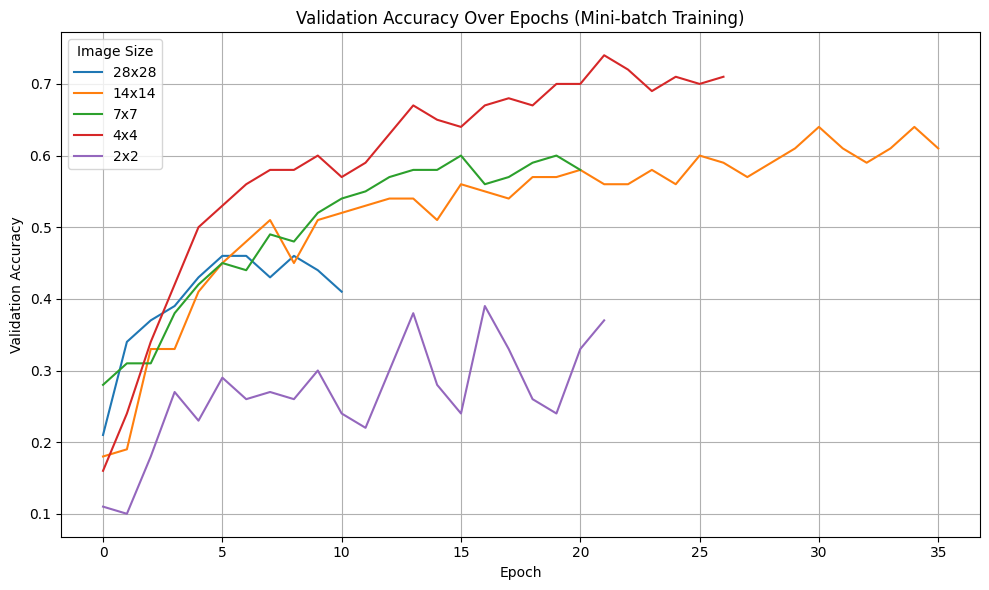

In [82]:
results_minibatch = {}
for size in sizes:
    print(f"\nEvaluating Image Size {size} x {size}:")
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(size)
    model = NN_2(input_size=size*size, hidden_size=32, output_size=10, activation_function=torch.relu)
    acc = train_minibatch(model, X_train, y_train, X_val, y_val, lr = 0.02, patience = 5)
    print(f"Mini-batch Accuracy: {acc[-1]:.2f}")
    results_minibatch[size] = acc

plt.figure(figsize=(10, 6))
for size in sizes:
    plt.plot(results_minibatch[size], label=f"{size}x{size}")
plt.title("Validation Accuracy Over Epochs (Mini-batch Training)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(title="Image Size")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Conclusion:** ####
Switching from full-batch to mini-batch training significantly improved validation accuracy across all image sizes. Larger images like 28×28 and 14×14 saw accuracy rise from about 22% to over 40%, while 4×4 improved dramatically from 48% to 70%. The 2×2 input saw more modest gains, limited by its low resolution. These results show that mini-batching improves generalization by adding gradient diversity and reducing overfitting.

## Mini-batch training (4-layers (64 neurons each)+ arctan activaton function)

In [83]:
class NN_3:
    def __init__(self, input_size, hidden_size=64, output_size=10, activation_function=torch.atan):
        self.activation_function = activation_function

        self.W1 = torch.empty(hidden_size, input_size).uniform_(-1, 1).requires_grad_()
        self.b1 = torch.zeros(hidden_size, requires_grad=True)

        self.W2 = torch.empty(hidden_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b2 = torch.zeros(hidden_size, requires_grad=True)

        self.W3 = torch.empty(hidden_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b3 = torch.zeros(hidden_size, requires_grad=True)

        self.W4 = torch.empty(hidden_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b4 = torch.zeros(hidden_size, requires_grad=True)

        self.W5 = torch.empty(output_size, hidden_size).uniform_(-1, 1).requires_grad_()
        self.b5 = torch.zeros(output_size, requires_grad=True)

    def forward(self, x):
        z1 = self.W1 @ x.T + self.b1[:, None]
        a1 = self.activation_function(z1)

        z2 = self.W2 @ a1 + self.b2[:, None]
        a2 = self.activation_function(z2)

        z3 = self.W3 @ a2 + self.b3[:, None]
        a3 = self.activation_function(z3)

        z4 = self.W4 @ a3 + self.b4[:, None]
        a4 = self.activation_function(z4)

        z5 = self.W5 @ a4 + self.b5[:, None]
        a5 = torch.softmax(z5, dim=0)
        return a5.T

    def zero_grad(self):
        for param in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3,
                      self.W4, self.b4, self.W5, self.b5]:
            if param.grad is not None:
                param.grad.zero_()

    def update(self, lr):
        with torch.no_grad():
            for param in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3,
                          self.W4, self.b4, self.W5, self.b5]:
                param -= lr * param.grad



Evaluating Image Size 28 x 28:
Mini-batch Accuracy: 0.40

Evaluating Image Size 14 x 14:
Mini-batch Accuracy: 0.60

Evaluating Image Size 7 x 7:
Mini-batch Accuracy: 0.80

Evaluating Image Size 4 x 4:
Mini-batch Accuracy: 0.72

Evaluating Image Size 2 x 2:
Mini-batch Accuracy: 0.30


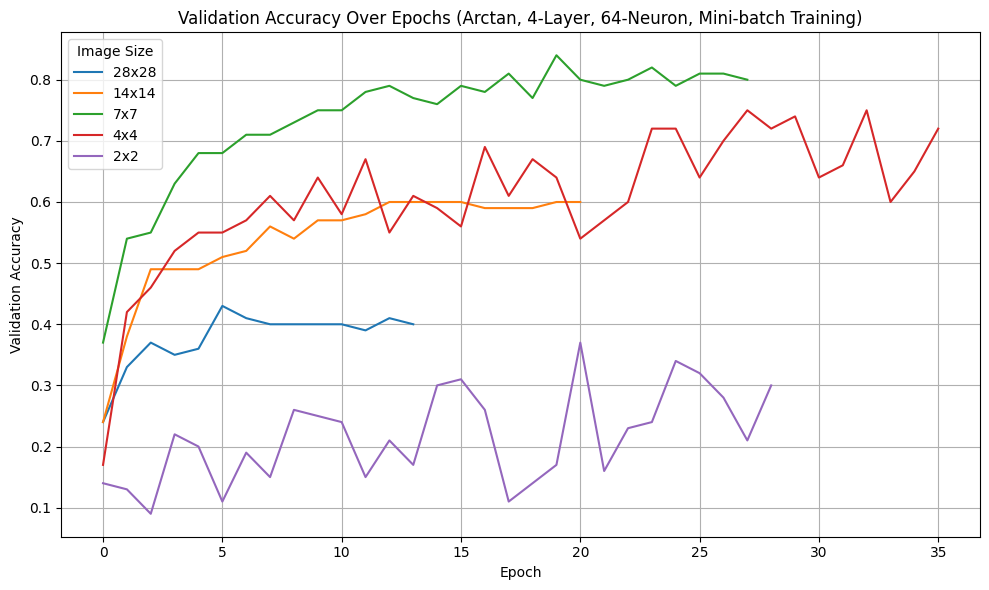

In [88]:
results_minibatch = {}
for size in sizes:
    print(f"\nEvaluating Image Size {size} x {size}:")
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(size)
    model = NN_3(input_size=size*size, hidden_size=64, output_size=10, activation_function=torch.atan)
    acc = train_minibatch(model, X_train, y_train, X_val, y_val, lr=0.07, patience=8)
    print(f"Mini-batch Accuracy: {acc[-1]:.2f}")
    results_minibatch[size] = acc

plt.figure(figsize=(10, 6))
for size in sizes:
    plt.plot(results_minibatch[size], label=f"{size}x{size}")
plt.title("Validation Accuracy Over Epochs (Arctan, 4-Layer, 64-Neuron, Mini-batch Training)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(title="Image Size")
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion:

| Image Size | Full-Batch<br>2 Layers, 16 Neurons, Sigmoid | Full-Batch<br>4 Layers, 32 Neurons, ReLU | Mini-Batch<br>4 Layers, 32 Neurons, ReLU | Mini-Batch<br>4 Layers, 64 Neurons, Arctan |
| ---------- | ------------------------------------------- | ---------------------------------------- | ---------------------------------------- | ------------------------------------------ |
| **28×28**  | 0.11                                        | 0.22                                     | 0.41                                     | 0.40                                       |
| **14×14**  | 0.27                                        | 0.23                                     | 0.61                                     | 0.60                                       |
| **7×7**    | 0.10                                        | 0.25                                     | 0.58                                     | 0.80                                       |
| **4×4**    | 0.18                                        | 0.48                                     | 0.71                                     | 0.72                                       |
| **2×2**    | 0.09                                        | 0.17                                     | 0.37                                     | 0.30                                       |


These results show that the depth of the network and the training method make a big difference in performance. The simple 2-layer network with sigmoid activation had the lowest accuracy across all image sizes. Using more layers and ReLU with full-batch training helped a bit, especially for 4×4 images. But switching to mini-batch training gave the biggest improvement, with much higher accuracy on 14×14 and 4×4 inputs. The best result came from mini-batch training with arctan activation and 64 neurons, reaching 80% accuracy on 7×7 images. Overall, deeper networks, better activation functions, and mini-batch training with balanced sampling helped the model learn and generalize much better.
